### The grand quest: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either pure __tensorflow__ or __keras__. Feel free to adapt the seminar code for your needs.


In [1]:
import pandas as pd
import numpy as np

In [4]:
data_path = 'data/'
data = pd.read_csv(data_path + 'Train_rev1.csv', index_col=None).sample(frac=1)

In [5]:
rubbish_columns = ['Id', 'LocationRaw', 'SalaryRaw', 'SourceName', 'SalaryNormalized']
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]

# Preprocessing

In [6]:
from sklearn.base import TransformerMixin
import sklearn.preprocessing
import nltk
from collections import Counter

In [7]:
def preprocess_general(data):
    new_data = pd.DataFrame(index=data.index)
    for column in text_columns + categorical_columns:
        new_data[column] = data[column]
    new_data = new_data.fillna('NaN')
    return new_data, np.log1p(data['SalaryNormalized']).astype('float32')

## Categorical data

In [8]:
class PreprocessCategorical(TransformerMixin):
    def __init__(self, min_company=40, min_city=20):
        self.le_category = sklearn.preprocessing.LabelEncoder()
        self.le_type = sklearn.preprocessing.LabelEncoder()
        self.city_counter = Counter()
        self.company_counter = Counter()
        self.min_company = min_company
        self.min_city = min_city
        self.mean = {}
        
    def _fit_category(self, data):
        self.le_category.fit(np.concatenate([data['Category'], ['other']]))
        
    def _fit_type(self, data):
        self.le_type.fit(data['ContractTime'] + data['ContractType'])
        
    def _fit_city_company(self, data, what, minimum, target):
        keys = {value if count >= minimum else 'other' for value, count in Counter(data[what]).most_common()}
        tmp_data = pd.DataFrame(index=data.index)
        tmp_data[what] = data[what].apply(lambda value: value if value in keys else 'other')
        tmp_data['Salary'] = target
        self.mean[what] = tmp_data.groupby(what)['Salary'].mean()
        
    def fit(self, data, target):
        self._fit_category(data)
        self._fit_city_company(data, 'LocationNormalized', self.min_city, target)
        self._fit_city_company(data, 'Company', self.min_company, target)
        self._fit_type(data)
        return self
    
    def _transform_category(self, data, new_data):
        new_data['Category'] = self.le_category.transform(data['Category'])
    
    def _transform_type(self, data, new_data):
        new_data['Contract'] = self.le_type.transform(data['ContractTime'] + data['ContractType'])
        
        
    def _transform_city_company(self, data, what, new_data):
        new_data[what] = data[what].apply(lambda value: self.mean[what].get(value, self.mean[what]['other']))
        
    def transform(self, data):
        new_data = pd.DataFrame(index=data.index)
        self._transform_category(data, new_data)
        self._transform_type(data, new_data)
        self._transform_city_company(data, 'LocationNormalized', new_data)
        self._transform_city_company(data, 'Company', new_data)
        for column in data:
            if column not in categorical_columns:
                new_data[column] = data[column]
        return new_data
        

## Text data

In [9]:
class PreprocessText(TransformerMixin):
    def __init__(self, min_count = 10):
        self.tokenizer = nltk.tokenize.WordPunctTokenizer()
        self.min_count = min_count
        
    def fit(self, data, target=None):
        token_counts = Counter(' '.join(data['Title']).split())
        token_counts += Counter(' '.join(data['FullDescription']).split())
        self.tokens = ["PAD", "UNK"] + [token for token, count in token_counts.items() if count >= self.min_count]
        self.token_to_id = {token: index for index, token in enumerate(self.tokens)}
        return self
    
    def transform(self, data):
        new_data = pd.DataFrame(index=data.index)
        for column in data:
            new_data[column] = data[column].apply(
                lambda text: list(map(lambda word: self.token_to_id.get(word, 0), 
                                      self.tokenizer.tokenize(str(text).lower()))
                                 )
            ) if column in text_columns else data[column]
        return new_data

## Applying preprocessing

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
data, target = preprocess_general(data)
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.3, random_state=325)

In [12]:
prep_text = PreprocessText()
prep_cat = PreprocessCategorical()
prep_text.fit(data_train)
prep_cat.fit(data_train, target_train)

In [13]:
data_train = prep_text.transform(prep_cat.transform(data_train))
data_test = prep_text.transform(prep_cat.transform(data_test))
vocab = prep_text.tokens

In [0]:
data_train.to_csv(data_path + 'data_prep_train.csv')
data_test.to_csv(data_path + 'data_prep_test.csv')
target_train.to_csv(data_path + 'target_train.csv')
target_test.to_csv(data_path + 'target_test.csv')
pd.DataFrame(vocab).to_csv(data_path + 'vocab.csv')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
rubbish_columns = ['Id', 'LocationRaw', 'SalaryRaw', 'SourceName', 'SalaryNormalized']
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]

In [0]:
data_path = '/content/gdrive/My Drive/ColabData/data_texts_2/'

In [0]:
import pandas as pd
import json
import numpy as np

data_train = pd.read_csv(data_path + 'data_prep_train.csv', index_col=0)
data_test = pd.read_csv(data_path + 'data_prep_test.csv', index_col=0)
for data in data_train, data_test:
    for column in text_columns:
        data[column] = data[column].apply(json.loads)
target_train = pd.read_csv(data_path + 'target_train.csv', index_col=0, header=None)
target_test = pd.read_csv(data_path + 'target_test.csv', index_col=0, header=None)
vocab = pd.read_csv(data_path + 'vocab.csv', index_col=0).values[:, 0]

assert data_train.shape[0] == target_train.shape[0]

# Batches iteration

In [0]:
def make_input(data):
    result = {}
    for column in ["Title", "FullDescription"]:
        max_len = max(map(len, data[column]))
        result[column] = np.zeros([data.shape[0], max_len])
        for index, line in enumerate(data[column]):
            result[column][index][:len(line)] = np.array(line)
            
    for col in ["Category", "Contract", "LocationNormalized", "Company"]:
        result[col] = np.array(data[col].values).reshape(data.shape[0])
    return result

def iter_batches(data, target=None, batch_size=100, shuffle=True, cycle=True):
    
    while True:
        indices = np.arange(data.shape[0])
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(data), batch_size):
            index = indices[start:start+batch_size]
            if target is not None:
                yield make_input(data.iloc[index]), target.iloc[index]
            else:
                yield make_input(data.iloc[index])
                
        if not cycle: break


# Model

In [7]:
import keras
import keras.layers as L

Using TensorFlow backend.


In [0]:
def create_categorical_output(category, contract, location, company, hid_size=64, category_size=16, contract_size=16):
    emb_category = L.Reshape((category_size,))(L.Embedding(29, category_size)(category))
    emb_contract = L.Reshape((contract_size,))(L.Embedding(9, contract_size)(contract))
    hidden_0 = L.Concatenate()([emb_category, emb_contract, location, company])
    return hidden_0
    
    
def create_embedings_model(emb_size=64):
    vocab_size=len(vocab)
    
    title = L.Input(shape=(None,), name='Title')
    descr = L.Input(shape=(None,), name='FullDescription')
    conv_out = []
    for input_l, filters, kernel_size in zip((title, descr), (128, 256), (2, 4)):
        emb = L.Embedding(vocab_size, emb_size)(input_l)
        conv = L.Conv1D(kernel_size=(kernel_size,), filters=filters, activation='relu')(emb)
        pool = L.GlobalMaxPool1D()(conv)
        conv_out.append(pool)
    concat = L.Concatenate()(conv_out)
    output = L.Dense(1)(concat)
    model = keras.models.Model(inputs=[title, descr], outputs=output)
    return model
    

def create_textual_output(text, filters, emb_l=None):
    if emb_l is None:
        emb_l = L.Embedding(len(vocab), 64)
    emb = emb_l(text)
    pools = []
    for kernel_size in (3, 4, 5):
        conv =  L.Conv1D(kernel_size=(kernel_size,), filters=filters, activation='relu')(emb)
        pools.append(L.GlobalMaxPool1D()(conv))
    return L.Concatenate()(pools)

def create_model(emb_title_l=None, emb_descr_l=None):
    inputs = (
        L.Input(shape=(1,), name="Category"),
        L.Input(shape=(1,), name="Contract"),
        L.Input(shape=(1,), name="LocationNormalized"),
        L.Input(shape=(1,), name="Company"),
        L.Input(shape=(None,), name='Title'),
        L.Input(shape=(None,), name='FullDescription'),
    )
    categorical_output = create_categorical_output(*inputs[:4])
    title_output = create_textual_output(inputs[4], filters=128, emb_l=emb_title_l)
    descr_output = create_textual_output(inputs[5], filters=128, emb_l=emb_descr_l)
    hidden_0 = L.Concatenate()([
        categorical_output, 
        title_output,
        descr_output,
    ])
    hidden_1 = L.Dense(128, activation='relu')(hidden_0)
    output = L.Dense(1)(hidden_1)
    model = keras.models.Model(inputs=inputs, outputs=output)
    return model

callbacks= [
    keras.callbacks.EarlyStopping(patience=2, monitor='val_loss',),
]

In [0]:
def count_embedings():
    model = create_embedings_model()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit_generator(
        iter_batches(data_train, target_train),
        steps_per_epoch=100,
        epochs=10
    )
    return {name: value for name, value in zip(('emb_title', 'emb_descr'), map(lambda layer: layer.get_weights()[0], model.layers[2: 4]))}

def get_emb_layers():
    layers = {}
    for name in ('emb_title', 'emb_descr'):
        weights = np.load(data_path+name + '.npy')
        layer = L.Embedding(*weights.shape,  weights=[weights], trainable=False)
        layers[name+'_l'] = layer
    return layers

In [16]:
embedings = count_embedings()
for name, value in embedings.items():
    np.save(data_path + name, value)

Epoch 1/10
100/100 [==============================] - 9s 86ms/step - loss: 24.3597
Epoch 2/10
100/100 [==============================] - 8s 77ms/step - loss: 0.3700
Epoch 3/10
100/100 [==============================] - 7s 71ms/step - loss: 0.2698
Epoch 4/10
100/100 [==============================] - 7s 66ms/step - loss: 0.2062
Epoch 5/10
100/100 [==============================] - 6s 65ms/step - loss: 0.1687
Epoch 6/10
100/100 [==============================] - 7s 67ms/step - loss: 0.1405
Epoch 7/10
100/100 [==============================] - 6s 62ms/step - loss: 0.1338
Epoch 8/10
100/100 [==============================] - 6s 60ms/step - loss: 0.1235
Epoch 9/10
100/100 [==============================] - 6s 60ms/step - loss: 0.1163
Epoch 10/10
100/100 [==============================] - 6s 63ms/step - loss: 0.1079


In [0]:
embedings = get_emb_layers()

In [22]:
model = create_model(**embedings)
model.summary()
model.compile(optimizer='adam', loss='mean_absolute_error')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Title (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
FullDescription (InputLayer)    (None, None)         0                                            
__________________________________________________________________________________________________
Category (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
Contract (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_

In [25]:
steps_per_epoch = (data_train.shape[0] - 1) // 100 + 1
history = model.fit_generator(
    iter_batches(data_train, target_train),
    validation_data=iter_batches(data_test, target_test),
    steps_per_epoch=data_test.shape[0] // 100,
    validation_steps=30,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
734/734 [==============================] - 48s 65ms/step - loss: 0.2763 - val_loss: 0.2062
Epoch 2/20
734/734 [==============================] - 48s 66ms/step - loss: 0.2129 - val_loss: 0.2133
Epoch 3/20
734/734 [==============================] - 45s 61ms/step - loss: 0.2037 - val_loss: 0.2028
Epoch 4/20
734/734 [==============================] - 43s 59ms/step - loss: 0.2005 - val_loss: 0.2019
Epoch 5/20
734/734 [==============================] - 44s 59ms/step - loss: 0.1973 - val_loss: 0.1928
Epoch 6/20
734/734 [==============================] - 44s 60ms/step - loss: 0.1932 - val_loss: 0.1931
Epoch 7/20
734/734 [==============================] - 43s 59ms/step - loss: 0.1933 - val_loss: 0.1888
Epoch 8/20
734/734 [==============================] - 43s 59ms/step - loss: 0.1868 - val_loss: 0.2031
Epoch 9/20
734/734 [==============================] - 44s 59ms/step - loss: 0.1865 - val_loss: 0.1884
Epoch 10/20
734/734 [==============================] - 44s 60ms/step - loss: 0.183

Text(0.5,1,'Learning curve')

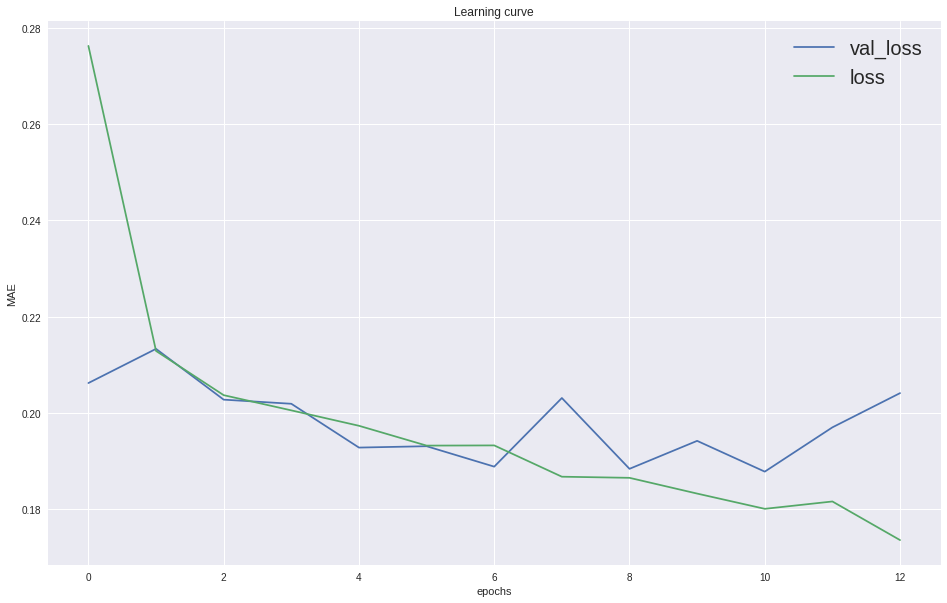

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 10))
plt.plot(np.arange(len(history.history['loss'])), history.history['val_loss'], label='val_loss')
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'], label='loss')
plt.legend(prop={'size': 20})
plt.xlabel('epochs')
plt.ylabel('MAE')
plt.title('Learning curve')

In [28]:
test_score = model.evaluate_generator(iter_batches(data_test, target_test), steps=data_test.shape[0]//100)
print('Mean absolute error on test data: {:0.3}'.format(test_score))

Mean absolute error on test data: 0.2


### A short report



1.  Изначально я собирался использовать и CNN и RNN, но RNN  существенно увеличивала время обчения, а добиться заметного увеличения качества от неё у меня не получилось, поэтому была оставлена только CNN.
2.  Обучение эмбедингов происходило в дополнительной простой моделе. Затем они использовались в основной моделе на порядок уменьшая количество оптимизируеых параметров
3.  Чтобы не получать некрасивые логи с `KeyboardInterrupt` во время обучения использовался `EarlyStopping` callback
4.  На этапе препроцессинга данные о компании и локации были заменены среднем значением таргета, (ContractTime, ContructType) и Category были закодированы. Тексты закодированы, как на семинаре.

Итоговый MAE на тесте: 0.218





## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time - our `L.GlobalMaxPool1D`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not want to use __`.get_keras_embedding()`__ method for word2vec
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback](https://keras.io/callbacks/#earlystopping).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!